In [1]:
# Imports & configuration
import os, json, math, time
from pathlib import Path
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import welch, spectrogram
from scipy.stats import skew, kurtosis, entropy
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Configuration
FILES = {
    'OFF': 'Motor_OFF.xlsx',
    'ON': 'Motor_ON.xlsx',
    'NO_FAN': 'Motor_NO_FAN.xlsx'
}

LABEL_MAP = {'OFF': 0, 'ON': 1, 'NO_FAN': 2}
WINDOW_SIZE = 256       # samples per window
STEP = 64               # INCREASED OVERLAP: more windows for training
DEFAULT_FS = 1000.0     # sampling frequency (Hz)
FIG_DIR = "./figs_improved"
os.makedirs(FIG_DIR, exist_ok=True)
RNG = 42
np.random.seed(RNG)
tf.random.set_seed(RNG)

In [2]:
# DATA LOADING
def load_data(path):

    df = pd.read_excel(path, engine='openpyxl')
    
    expected_cols = ['timestamp', 'Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz']
    if not all(col in df.columns for col in expected_cols):
        raise ValueError(f"File {path} missing expected columns. Found: {df.columns.tolist()}")
    
    df = df[expected_cols].copy()

    try:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
    except Exception:
        df['timestamp'] = np.arange(len(df))
    
    return df

def infer_fs_from_timestamp(df):
    try:
        ts = pd.to_datetime(df['timestamp'])
        dt = (ts - ts.shift(1)).dropna().dt.total_seconds().values
        if len(dt) == 0:
            return DEFAULT_FS
        median_dt = np.median(dt)
        if median_dt <= 0:
            return DEFAULT_FS
        return 1.0 / median_dt
    except Exception:
        return DEFAULT_FS

def compute_vector_magnitude(df):
    ax = df['Ax'].to_numpy(dtype=float)
    ay = df['Ay'].to_numpy(dtype=float)
    az = df['Az'].to_numpy(dtype=float)
    gx = df['Gx'].to_numpy(dtype=float)
    gy = df['Gy'].to_numpy(dtype=float)
    gz = df['Gz'].to_numpy(dtype=float)
    
    df['accel_mag'] = np.sqrt(ax*ax + ay*ay + az*az)
    df['gyro_mag'] = np.sqrt(gx*gx + gy*gy + gz*gz)
    return df

In [3]:
# LOAD DATASETS

data_dfs = {}
fs_map = {}
print("Loading files...")
for label, path in FILES.items():
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing file: {path} - place it in working dir")
    df = load_data(path)
    df = compute_vector_magnitude(df)
    data_dfs[label] = df
    fs_map[label] = infer_fs_from_timestamp(df)
    print(f"Loaded {label}: {df.shape}, inferred fs={fs_map[label]:.2f} Hz")

FS = float(np.median(list(fs_map.values())))
print(f"Using FS = {FS} Hz")

Loading files...
Loaded OFF: (9000, 9), inferred fs=1000.00 Hz
Loaded ON: (9000, 9), inferred fs=1000.00 Hz
Loaded NO_FAN: (9000, 9), inferred fs=1000.00 Hz
Using FS = 1000.0 Hz



Summary stats for OFF:
 Accel mean: [ 0.02581 -0.3032   0.67771], std: [0.00757 0.51025 0.4595 ]
 Gyro mean: [-0.694   -0.0999  -0.36271], std: [0.20695 0.167   0.04014]
 accel_mag mean/std: 1.01161, 0.00954
 gyro_mag mean/std: 0.81525, 0.17575
 n_samples: 9000


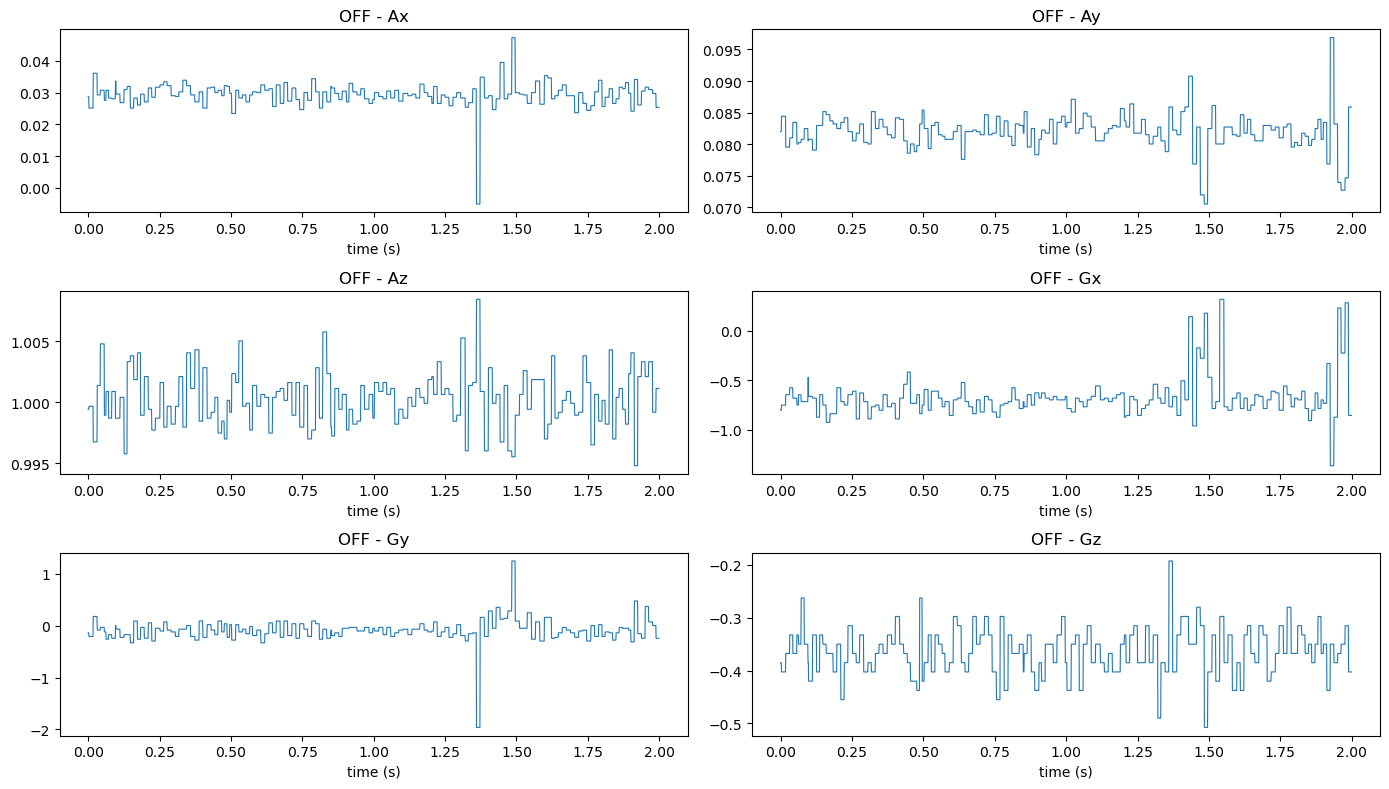

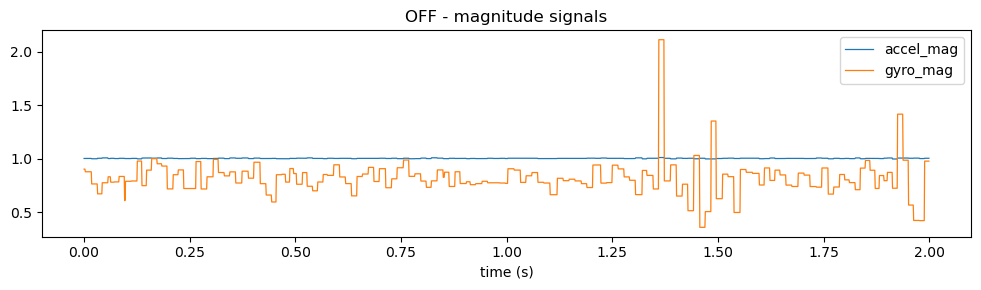


Summary stats for ON:
 Accel mean: [ 0.0086  -0.27347  0.71402], std: [0.17941 0.61636 0.56207]
 Gyro mean: [-1.03677 -0.05278 -0.15651], std: [11.91877  5.25607  7.413  ]
 accel_mag mean/std: 1.08942, 0.35481
 gyro_mag mean/std: 12.08921, 8.92176
 n_samples: 9000


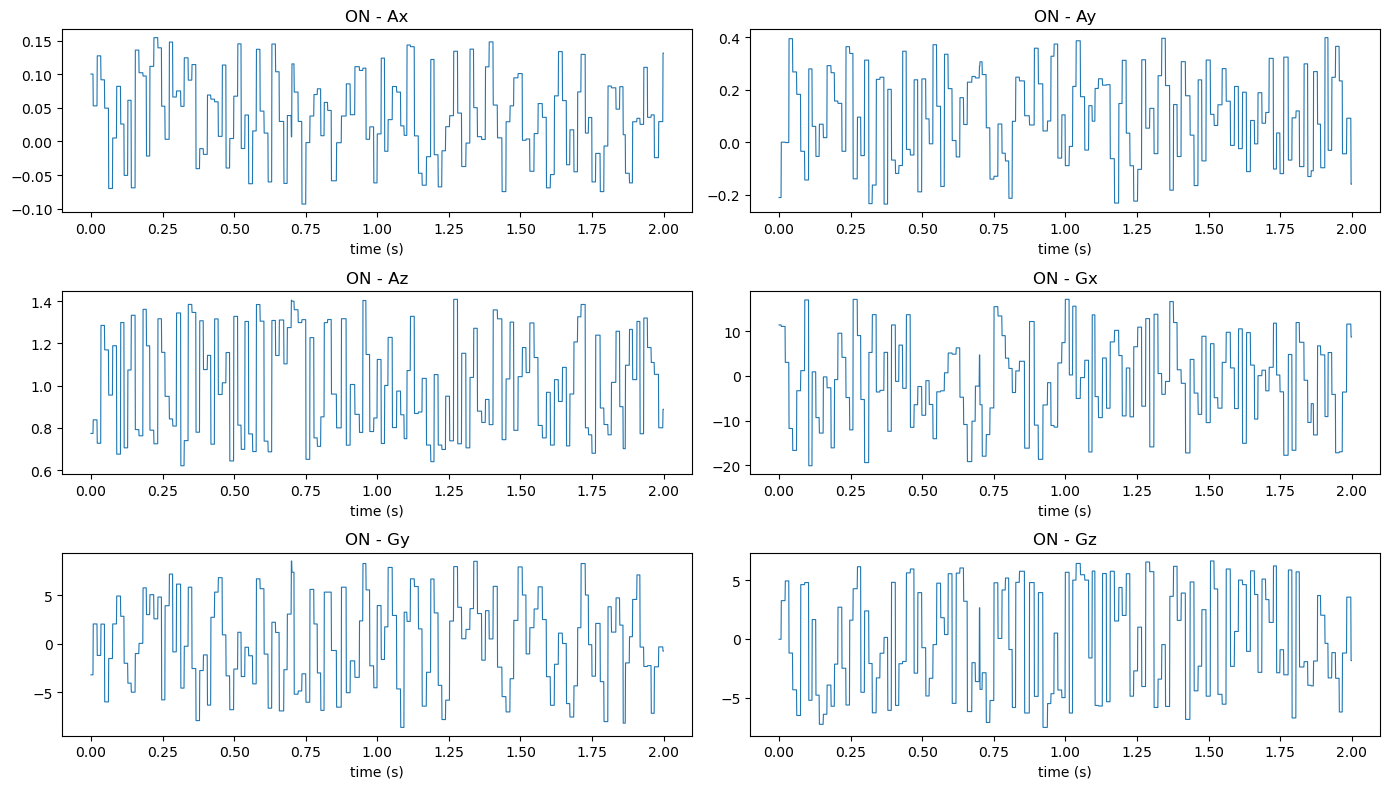

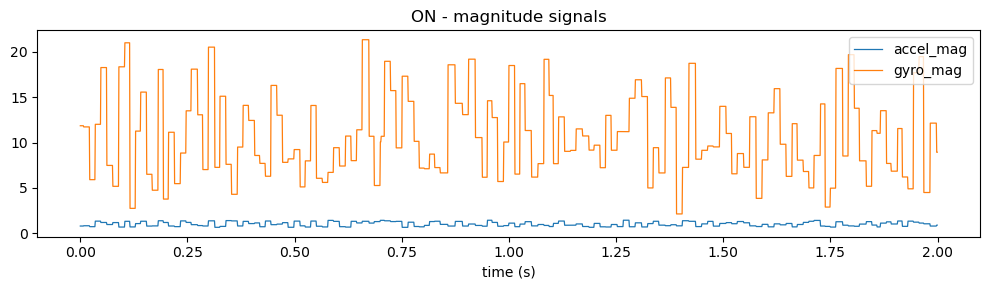


Summary stats for NO_FAN:
 Accel mean: [ 0.00353 -0.31596  0.69165], std: [0.23546 0.71157 0.61843]
 Gyro mean: [-0.12849  0.46691  0.30782], std: [13.91945  9.02041  9.06158]
 accel_mag mean/std: 1.14239, 0.46628
 gyro_mag mean/std: 14.91582, 11.62299
 n_samples: 9000


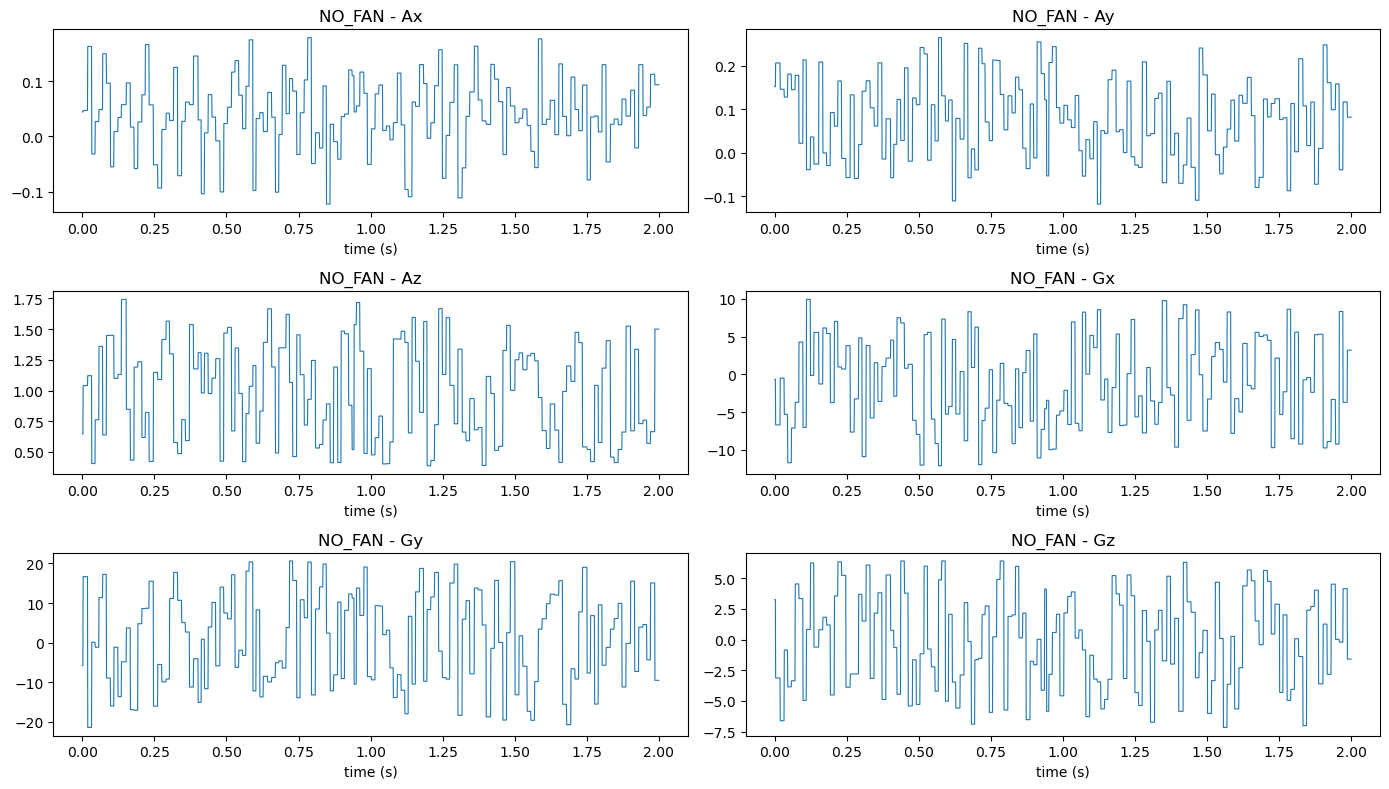

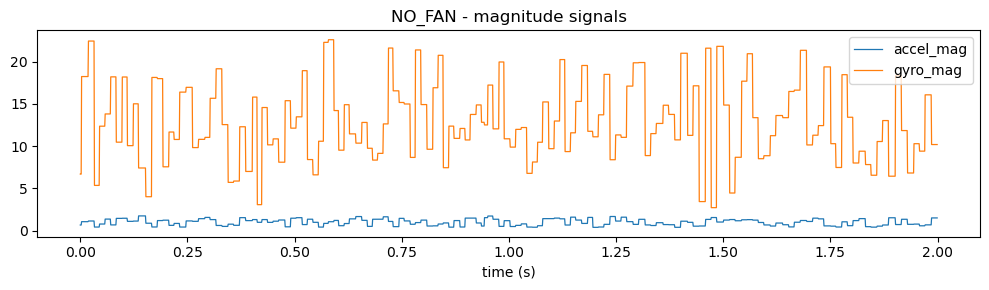

In [4]:
# EDA FUNCTIONS

def plot_time_channels(df, label, n_samples=2000, fs=FS, save=False):
    n = min(len(df), n_samples)
    t = np.arange(n) / fs
    fig, axs = plt.subplots(3, 2, figsize=(14, 8))
    axs = axs.flatten()
    cols = ['Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz']
    for i, ch in enumerate(cols):
        axs[i].plot(t, df[ch].values[:n], lw=0.8)
        axs[i].set_title(f"{label} - {ch}")
        axs[i].set_xlabel("time (s)")
    plt.tight_layout()
    if save:
        plt.savefig(os.path.join(FIG_DIR, f"{label}_raw_timeseries.png"), dpi=200)
    plt.show()

def plot_magnitude_signals(df, label, n_samples=2000, fs=FS, save=False):
    n = min(len(df), n_samples)
    t = np.arange(n) / fs
    plt.figure(figsize=(10, 3))
    plt.plot(t, df['accel_mag'].values[:n], label='accel_mag', lw=0.9)
    plt.plot(t, df['gyro_mag'].values[:n], label='gyro_mag', lw=0.9)
    plt.title(f"{label} - magnitude signals")
    plt.xlabel("time (s)")
    plt.legend()
    plt.tight_layout()
    if save:
        plt.savefig(os.path.join(FIG_DIR, f"{label}_magnitudes.png"), dpi=200)
    plt.show()

def summary_stats(df, label):
    print(f"\nSummary stats for {label}:")
    for grp, cols in [('Accel', ['Ax', 'Ay', 'Az']), ('Gyro', ['Gx', 'Gy', 'Gz'])]:
        arr = df[cols].to_numpy()
        print(f" {grp} mean: {np.round(arr.mean(axis=0), 5)}, std: {np.round(arr.std(axis=0), 5)}")
    print(f" accel_mag mean/std: {df['accel_mag'].mean():.5f}, {df['accel_mag'].std():.5f}")
    print(f" gyro_mag mean/std: {df['gyro_mag'].mean():.5f}, {df['gyro_mag'].std():.5f}")
    print(f" n_samples: {len(df)}")

# Run EDA
for label, df in data_dfs.items():
    summary_stats(df, label)
    plot_time_channels(df, label, n_samples=2000, save=True)
    plot_magnitude_signals(df, label, n_samples=2000, save=True)

In [5]:
# ENHANCED FEATURE ENGINEERING

def cov_eigenvalues(window):
    #Covariance eigenvalues (orientation-invariant)."""
    C = np.cov(window.T)
    eigs = np.linalg.eigvalsh(C)
    return np.sort(eigs)[::-1]

def make_windows_and_features(df, window_size=WINDOW_SIZE, step=STEP, fs=FS):
    # Extract all 6 channels
    arr_acc = df[['Ax', 'Ay', 'Az']].to_numpy(dtype=np.float32)
    arr_gyro = df[['Gx', 'Gy', 'Gz']].to_numpy(dtype=np.float32)
    mag_acc = df['accel_mag'].to_numpy(dtype=np.float32)
    mag_gyro = df['gyro_mag'].to_numpy(dtype=np.float32)
    
    n = arr_acc.shape[0]
    windows_ts = []
    feat_list = []
    
    for start in range(0, n - window_size + 1, step):
        a_win = arr_acc[start:start+window_size]      # ws x 3
        g_win = arr_gyro[start:start+window_size]     # ws x 3
        am_win = mag_acc[start:start+window_size]     # ws
        gm_win = mag_gyro[start:start+window_size]    # ws
        
        ts = np.concatenate([a_win, g_win], axis=1)   # ws x 6
        windows_ts.append(ts)
        
        feats = []
        
        for v in (am_win, gm_win):
            feats += [
                v.mean(), v.std(), np.sqrt(np.mean(v*v)), 
                v.max() - v.min(), skew(v), kurtosis(v)
            ]
        
        a_eigs = cov_eigenvalues(a_win)
        g_eigs = cov_eigenvalues(g_win)
        feats += a_eigs.tolist() + g_eigs.tolist()
        
        for v in (am_win, gm_win):
            N = len(v)
            S = np.abs(np.fft.rfft(v * np.hanning(N)))
            freqs = np.fft.rfftfreq(N, d=1.0/fs)
            if S.sum() == 0:
                dom = 0.0
                centroid = 0.0
            else:
                dom = freqs[np.argmax(S)]
                centroid = (S * freqs).sum() / S.sum()
            feats += [dom, centroid]
        
        bands = [(0, 50), (50, 150), (150, 300), (300, fs/2)]
        for v in (am_win, gm_win):
            N = len(v)
            S = np.abs(np.fft.rfft(v * np.hanning(N)))**2
            freqs = np.fft.rfftfreq(N, d=1.0/fs)
            for (fmin, fmax) in bands:
                idx = np.where((freqs >= fmin) & (freqs < fmax))[0]
                feats.append(S[idx].sum() if len(idx) > 0 else 0.0)
        
        if len(am_win) > 0 and len(gm_win) > 0:
            corr = np.corrcoef(am_win, gm_win)[0, 1]
            feats.append(corr if not np.isnan(corr) else 0.0)
        else:
            feats.append(0.0)
        
        for v in (am_win, gm_win):
            hist, _ = np.histogram(v, bins=20, density=True)
            hist = hist + 1e-12  # avoid log(0)
            feats.append(entropy(hist))
        
        for v in (am_win, gm_win):
            mean_v = v.mean()
            std_v = v.std()
            threshold = mean_v + 1.5 * std_v
            peaks = np.sum((v[1:-1] > v[:-2]) & (v[1:-1] > v[2:]) & (v[1:-1] > threshold))
            feats.append(peaks)
        
        accel_energy = np.sum(am_win**2)
        gyro_energy = np.sum(gm_win**2)
        ratio = gyro_energy / (accel_energy + 1e-12)
        feats.append(ratio)
        
        feat_list.append(np.array(feats, dtype=np.float32))
    
    X_ts = np.stack(windows_ts, axis=0)
    X_feat = np.stack(feat_list, axis=0)
    return X_ts, X_feat

X_parts_ts = []
X_parts_feat = []
y_parts = []

for label, df in data_dfs.items():
    X_ts, X_feat = make_windows_and_features(df, window_size=WINDOW_SIZE, step=STEP, fs=FS)
    X_parts_ts.append(X_ts)
    X_parts_feat.append(X_feat)
    y_parts.append(np.full((X_ts.shape[0],), LABEL_MAP[label], dtype=int))
    print(f"{label}: windows={X_ts.shape[0]}, ts_shape={X_ts.shape}, feat_shape={X_feat.shape}")

X_ts = np.concatenate(X_parts_ts, axis=0)
X_feat = np.concatenate(X_parts_feat, axis=0)
y = np.concatenate(y_parts, axis=0)
print(f"\nTotal windows: {X_ts.shape}, Feature matrix: {X_feat.shape}")
print(f"Label distribution: {Counter(y)}")

# Shuffle
X_ts, X_feat, y = shuffle(X_ts, X_feat, y, random_state=RNG)

OFF: windows=137, ts_shape=(137, 256, 6), feat_shape=(137, 36)
ON: windows=137, ts_shape=(137, 256, 6), feat_shape=(137, 36)
NO_FAN: windows=137, ts_shape=(137, 256, 6), feat_shape=(137, 36)

Total windows: (411, 256, 6), Feature matrix: (411, 36)
Label distribution: Counter({0: 137, 1: 137, 2: 137})


In [6]:
# Train/val/test split
X_train_ts, X_temp_ts, X_train_feat, X_temp_feat, y_train, y_temp = train_test_split(
    X_ts, X_feat, y, test_size=0.30, stratify=y, random_state=RNG
)
X_val_ts, X_test_ts, X_val_feat, X_test_feat, y_val, y_test = train_test_split(
    X_temp_ts, X_temp_feat, y_temp, test_size=0.50, stratify=y_temp, random_state=RNG
)
print(f"Train/Val/Test: {X_train_ts.shape[0]}/{X_val_ts.shape[0]}/{X_test_ts.shape[0]}")

# Standardize features
feat_scaler = StandardScaler().fit(X_train_feat)
X_train_feat = feat_scaler.transform(X_train_feat)
X_val_feat = feat_scaler.transform(X_val_feat)
X_test_feat = feat_scaler.transform(X_test_feat)

# Standardize time-series (per channel)
for ch in range(X_train_ts.shape[2]):
    scaler = StandardScaler().fit(X_train_ts[:, :, ch])
    X_train_ts[:, :, ch] = scaler.transform(X_train_ts[:, :, ch])
    X_val_ts[:, :, ch] = scaler.transform(X_val_ts[:, :, ch])
    X_test_ts[:, :, ch] = scaler.transform(X_test_ts[:, :, ch])

Train/Val/Test: 287/62/62


In [7]:
# DATA AUGMENTATION
def augment_ts(window):
    w = window.copy()
    
    # Jitter
    if np.random.rand() < 0.7:
        w += np.random.normal(0, 0.02, w.shape)
    
    # Scaling per channel
    if np.random.rand() < 0.5:
        scale = np.random.normal(1.0, 0.08, (1, w.shape[1]))
        w = w * scale
    
    # Time shift
    if np.random.rand() < 0.4:
        shift = int(np.random.uniform(-0.1, 0.1) * w.shape[0])
        w = np.roll(w, shift, axis=0)
    
    # Small rotation (mix channels slightly - simulates orientation change)
    if np.random.rand() < 0.3:
        angle = np.random.uniform(-0.1, 0.1)
        cos_a, sin_a = np.cos(angle), np.sin(angle)
        # Rotate accel x-y
        w[:, [0, 1]] = w[:, [0, 1]] @ np.array([[cos_a, -sin_a], [sin_a, cos_a]])
        # Rotate gyro x-y
        w[:, [3, 4]] = w[:, [3, 4]] @ np.array([[cos_a, -sin_a], [sin_a, cos_a]])
    
    return w

def balance_and_augment(X_ts_arr, X_feat_arr, y_arr, target_count=None):
    uniq, counts = np.unique(y_arr, return_counts=True)
    if target_count is None:
        target_count = int(max(counts) * 1.5)  # Oversample more aggressively
    
    pieces_ts, pieces_feat, pieces_y = [], [], []
    
    for cls in uniq:
        idxs = np.where(y_arr == cls)[0]
        pieces_ts.append(X_ts_arr[idxs])
        pieces_feat.append(X_feat_arr[idxs])
        pieces_y.append(y_arr[idxs])
        
        n_cur = len(idxs)
        if n_cur < target_count:
            need = target_count - n_cur
            choices = np.random.choice(idxs, size=need, replace=True)
            aug_ts = np.stack([augment_ts(X_ts_arr[c]) for c in choices], axis=0)
            aug_feat = X_feat_arr[choices]
            pieces_ts.append(aug_ts)
            pieces_feat.append(aug_feat)
            pieces_y.append(np.full((need,), cls, dtype=int))
    
    Xb_ts = np.concatenate(pieces_ts, axis=0)
    Xb_feat = np.concatenate(pieces_feat, axis=0)
    yb = np.concatenate(pieces_y, axis=0)
    perm = np.random.permutation(len(yb))
    return Xb_ts[perm], Xb_feat[perm], yb[perm]

print(f"\nOriginal train label counts: {Counter(y_train)}")
Xb_train_ts, Xb_train_feat, yb_train = balance_and_augment(X_train_ts, X_train_feat, y_train)
print(f"Balanced train label counts: {Counter(yb_train)}")

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(yb_train), y=yb_train)
class_weight_dict = {i: w for i, w in enumerate(class_weights)}
print(f"Class weights: {class_weight_dict}")


Original train label counts: Counter({0: 96, 1: 96, 2: 95})
Balanced train label counts: Counter({2: 144, 0: 144, 1: 144})
Class weights: {0: 1.0, 1: 1.0, 2: 1.0}


In [8]:
# MODEL ARCHITECTURE

def focal_loss_tf(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_true_onehot = tf.one_hot(tf.cast(tf.reshape(y_true, [-1]), tf.int32), 
                                    depth=tf.shape(y_pred)[-1])
        p_t = tf.reduce_sum(y_true_onehot * y_pred, axis=-1)
        p_t = tf.clip_by_value(p_t, 1e-8, 1.0)
        loss_val = -alpha * tf.pow(1.0 - p_t, gamma) * tf.math.log(p_t)
        return tf.reduce_mean(loss_val)
    return loss

def build_improved_model(input_ts_shape, input_feat_dim, num_classes, l2_reg=5e-4):
    # Time-series branch (6 channels)
    ts_in = keras.Input(shape=input_ts_shape, name='ts_input')
    x = ts_in
    
    # Conv blocks with residuals
    for filters, kernel in [(64, 5), (96, 3), (128, 3), (128, 3)]:
        y = layers.Conv1D(filters, kernel, padding='same', activation=None,
                         kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
        y = layers.BatchNormalization()(y)
        y = layers.Activation('relu')(y)
        y = layers.Conv1D(filters, kernel, padding='same', activation=None,
                         kernel_regularizer=keras.regularizers.l2(l2_reg))(y)
        y = layers.BatchNormalization()(y)
        
        # Projection if needed
        if x.shape[-1] != filters:
            x = layers.Conv1D(filters, 1, padding='same')(x)
        
        x = layers.Add()([x, y])
        x = layers.Activation('relu')(x)
        x = layers.Dropout(0.2)(x)
        x = layers.MaxPooling1D(2)(x)
    
    # Simple attention mechanism
    attention = layers.Dense(1, activation='tanh')(x)
    attention = layers.Softmax(axis=1)(attention)
    x_attended = layers.Multiply()([x, attention])
    x = layers.GlobalAveragePooling1D()(x_attended)
    
    # Feature branch
    feat_in = keras.Input(shape=(input_feat_dim,), name='feat_input')
    f = layers.Dense(256, activation='relu', 
                    kernel_regularizer=keras.regularizers.l2(l2_reg))(feat_in)
    f = layers.BatchNormalization()(f)
    f = layers.Dropout(0.3)(f)
    f = layers.Dense(128, activation='relu',
                    kernel_regularizer=keras.regularizers.l2(l2_reg))(f)
    f = layers.BatchNormalization()(f)
    f = layers.Dropout(0.2)(f)
    
    # Fusion
    concat = layers.Concatenate()([x, f])
    h = layers.Dense(256, activation='relu',
                    kernel_regularizer=keras.regularizers.l2(l2_reg))(concat)
    h = layers.BatchNormalization()(h)
    h = layers.Dropout(0.4)(h)
    h = layers.Dense(128, activation='relu',
                    kernel_regularizer=keras.regularizers.l2(l2_reg))(h)
    h = layers.Dropout(0.3)(h)
    
    out = layers.Dense(num_classes, activation='softmax')(h)
    
    model = keras.Model(inputs=[ts_in, feat_in], outputs=out, name='improved_hybrid')
    return model

# Build model
input_ts_shape = Xb_train_ts.shape[1:]  # (window_size, 6)
input_feat_dim = Xb_train_feat.shape[1]
num_classes = len(np.unique(yb_train))

model = build_improved_model(input_ts_shape, input_feat_dim, num_classes)
model.summary()
print(f"\nTotal params: {model.count_params()}")

Model: "improved_hybrid"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ts_input            │ (None, 256, 6)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 256, 64)   │      1,984 │ ts_input[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 64)   │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 256, 64)   │     20,544 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 256, 64)   │        448 │ ts_input[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 64)   │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256, 64)   │          0 │ conv1d_2[0][0],   │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 64)   │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 64)   │          0 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 128, 64)   │          0 │ dropout[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 128, 96)   │     18,528 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 96)   │        384 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 96)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 128, 96)   │     27,744 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 128, 96)   │      6,240 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 96)   │        384 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 128, 96)   │          0 │ conv1d_5[0][0],   │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 96)   │          0 │ add_1[0][0]       │
│ (Activation)        │                   │            │                 

 Total params: 420,196 (1.60 MB)

 Trainable params: 417,252 (1.59 MB)

 Non-trainable params: 2,944 (11.50 KB)


Total params: 420196


In [9]:
# TRAINING
loss_fn = focal_loss_tf(gamma=2.0, alpha=0.25)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-4),
    loss=loss_fn,
    metrics=['accuracy']
)

callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=8, min_lr=1e-6, verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=20, restore_best_weights=True, verbose=1
    )
]

print("\nTraining model...")
history = model.fit(
    [Xb_train_ts, Xb_train_feat], yb_train,
    validation_data=([X_val_ts, X_val_feat], y_val),
    epochs=150,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=2
)


Training model...
Epoch 1/150
14/14 - 4s - 297ms/step - accuracy: 0.4444 - loss: 0.9778 - val_accuracy: 0.5968 - val_loss: 0.7720 - learning_rate: 5.0000e-04
Epoch 2/150
14/14 - 1s - 42ms/step - accuracy: 0.6852 - loss: 0.7614 - val_accuracy: 0.5968 - val_loss: 0.7407 - learning_rate: 5.0000e-04
Epoch 3/150
14/14 - 1s - 40ms/step - accuracy: 0.7269 - loss: 0.7323 - val_accuracy: 0.6452 - val_loss: 0.7023 - learning_rate: 5.0000e-04
Epoch 4/150
14/14 - 1s - 43ms/step - accuracy: 0.7894 - loss: 0.6829 - val_accuracy: 0.7742 - val_loss: 0.6664 - learning_rate: 5.0000e-04
Epoch 5/150
14/14 - 1s - 44ms/step - accuracy: 0.8380 - loss: 0.6486 - val_accuracy: 0.8226 - val_loss: 0.6352 - learning_rate: 5.0000e-04
Epoch 6/150
14/14 - 1s - 45ms/step - accuracy: 0.8287 - loss: 0.6217 - val_accuracy: 0.8710 - val_loss: 0.6085 - learning_rate: 5.0000e-04
Epoch 7/150
14/14 - 1s - 45ms/step - accuracy: 0.8218 - loss: 0.5917 - val_accuracy: 0.8710 - val_loss: 0.5861 - learning_rate: 5.0000e-04
Epoch 8

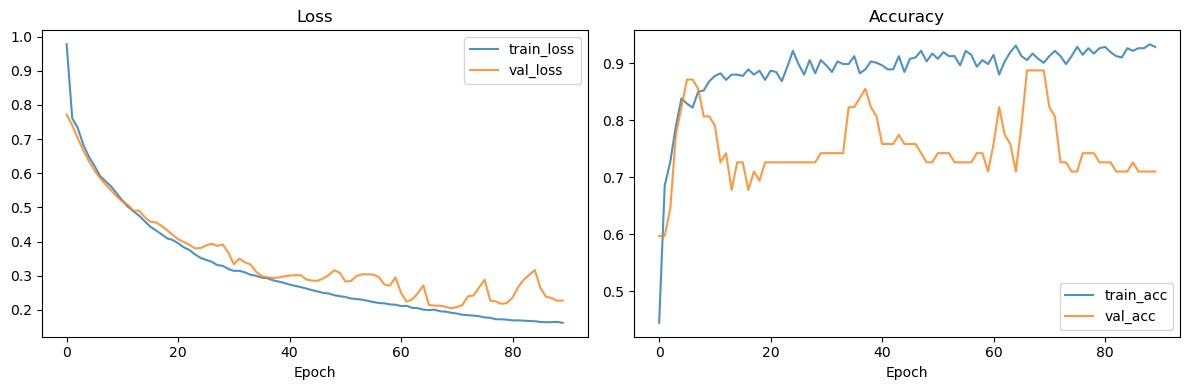


TEST RESULTS
Test loss: 0.1915
Test accuracy: 0.9032
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step

Classification Report:
              precision    recall  f1-score   support

         OFF       1.00      1.00      1.00        21
          ON       0.85      0.85      0.85        20
      NO_FAN       0.86      0.86      0.86        21

    accuracy                           0.90        62
   macro avg       0.90      0.90      0.90        62
weighted avg       0.90      0.90      0.90        62


Confusion Matrix:
[[21  0  0]
 [ 0 17  3]
 [ 0  3 18]]


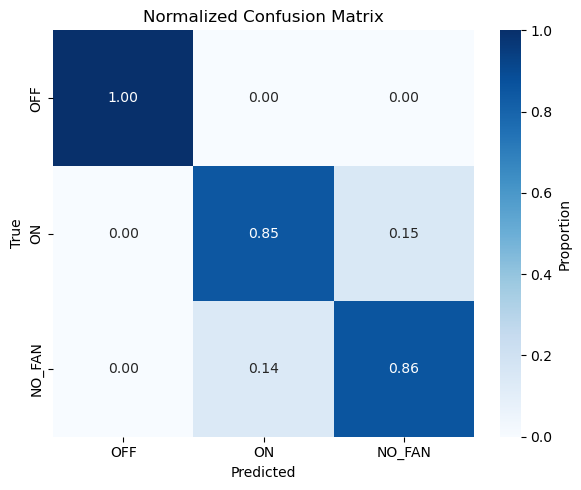

In [10]:
# EVALUATION

# Training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss', alpha=0.8)
plt.plot(history.history['val_loss'], label='val_loss', alpha=0.8)
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_acc', alpha=0.8)
plt.plot(history.history.get('val_accuracy', []), label='val_acc', alpha=0.8)
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'training_curves.png'), dpi=200)
plt.show()

# Test evaluation
test_loss, test_acc = model.evaluate([X_test_ts, X_test_feat], y_test, verbose=0)
print(f"\n{'='*60}")
print(f"TEST RESULTS")
print(f"{'='*60}")
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

y_prob = model.predict([X_test_ts, X_test_feat])
y_pred = np.argmax(y_prob, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=list(LABEL_MAP.keys()), 
                          zero_division=0))

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Confusion matrix heatmap
plt.figure(figsize=(6, 5))
cm_norm = cm.astype(float) / (cm.sum(axis=1, keepdims=True) + 1e-12)
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=list(LABEL_MAP.keys()), 
            yticklabels=list(LABEL_MAP.keys()),
            cbar_kws={'label': 'Proportion'})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'confusion_matrix.png'), dpi=200)
plt.show()